In [33]:
# Importing required libraries
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neighbors import LocalOutlierFactor


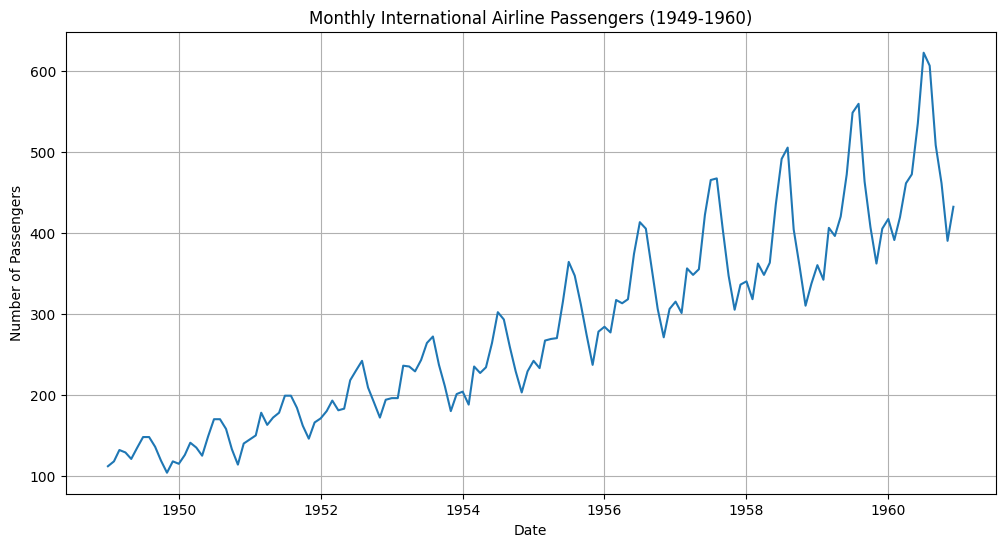

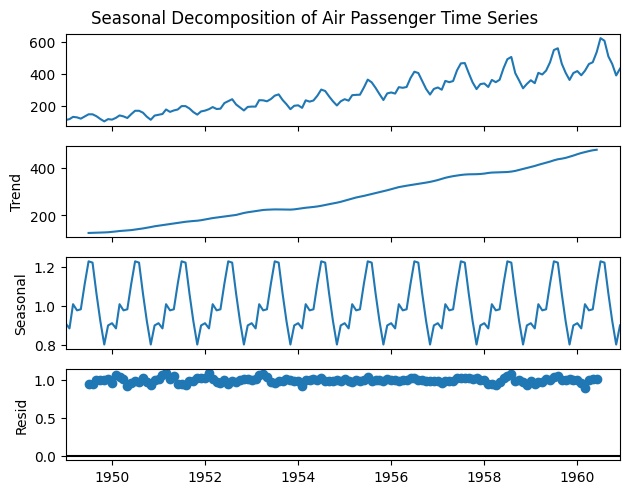

In [13]:
#1. Load a time series dataset of Air Passengers, plot the original series, and decompose it into trend, seasonality, and residual components

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# 2. Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title('Monthly International Airline Passengers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

# 3. Decompose the series into trend, seasonal, and residual components
# Use a multiplicative model because the seasonality increases with the trend
decomposition = seasonal_decompose(df, model='multiplicative', period=12)

# 4. Plot the decomposed components
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Air Passenger Time Series', y=1.02)
plt.show()



Number of detected anomalies: 280
Number of normal points: 720


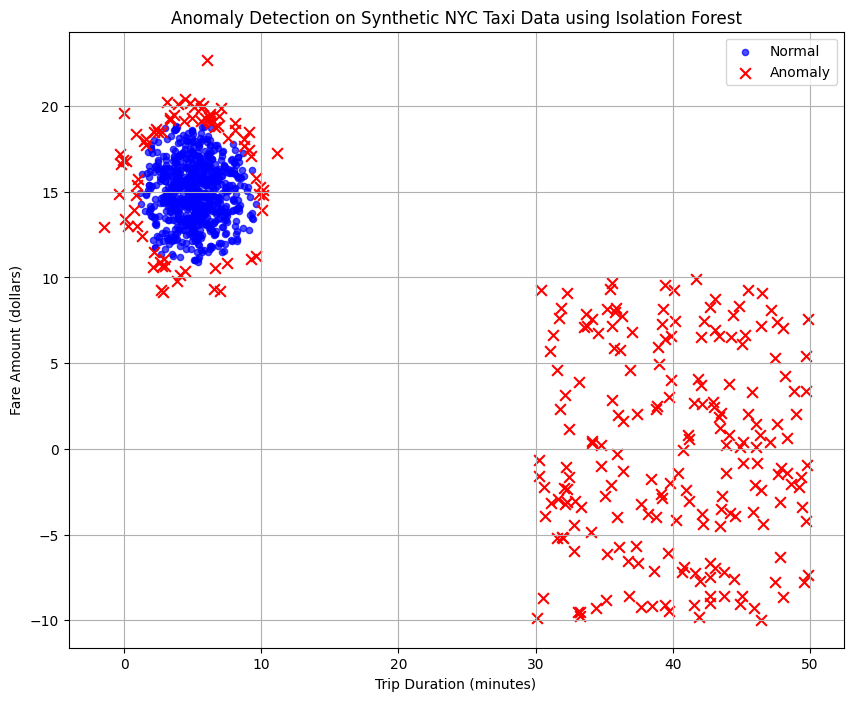

In [26]:
#2. Apply Isolation Forest on a numerical dataset (e.g., NYC Taxi Fare) to detect anomalies. Visualize the anomalies on a 2D scatter plot.


from sklearn.ensemble import IsolationForest

# Set random seed for reproducibility
rng = np.random.RandomState(42)

# Generate synthetic normal data resembling NYC taxi fares
# 800 samples of normal behavior
normal_data = rng.randn(800, 2) * 2 + np.array([5, 15])

# Generate synthetic outliers
# 200 samples of anomalous behavior (e.g., very high fare, short trip)
outlier_data = rng.rand(200, 2) * 20 + np.array([30, 20])
outlier_data[:, 1] = outlier_data[:, 1] - 30 # Adjust to create low trip duration anomalies

# Combine the datasets
X = np.r_[normal_data, outlier_data]

# Put the data into a pandas DataFrame for easier handling
df = pd.DataFrame(X, columns=['trip_duration_minutes', 'fare_amount_dollars'])

# Initialize and train the Isolation Forest model
model = IsolationForest(
    n_estimators=100,      # Number of trees in the forest
    contamination='auto',  # Proportion of outliers in the dataset
    random_state=rng       # Seed for reproducibility
)
model.fit(df)


# Predict anomalies (-1 for anomalies, 1 for normal points)
df['anomaly'] = model.predict(df[['trip_duration_minutes', 'fare_amount_dollars']])

# Separate normal and anomalous data points
anomalies = df[df['anomaly'] == -1]
normal_points = df[df['anomaly'] == 1]

print(f"Number of detected anomalies: {len(anomalies)}")
print(f"Number of normal points: {len(normal_points)}")

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(
    normal_points['trip_duration_minutes'],
    normal_points['fare_amount_dollars'],
    c='blue',
    s=20,
    label='Normal',
    alpha=0.7
)
plt.scatter(
    anomalies['trip_duration_minutes'],
    anomalies['fare_amount_dollars'],
    c='red',
    s=60,
    marker='x',
    label='Anomaly'
)
plt.title('Anomaly Detection on Synthetic NYC Taxi Data using Isolation Forest')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount (dollars)')
plt.legend()
plt.grid(True)
plt.show()


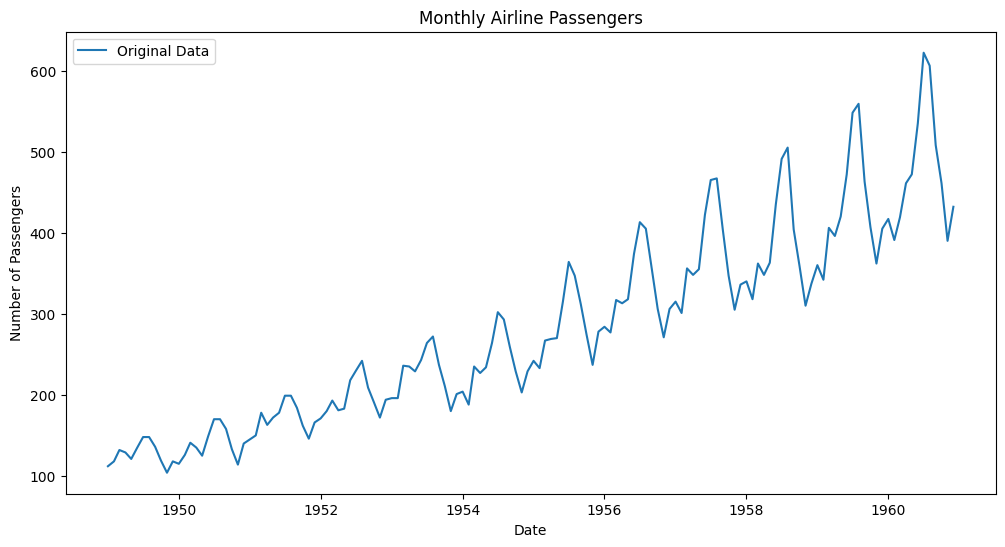

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


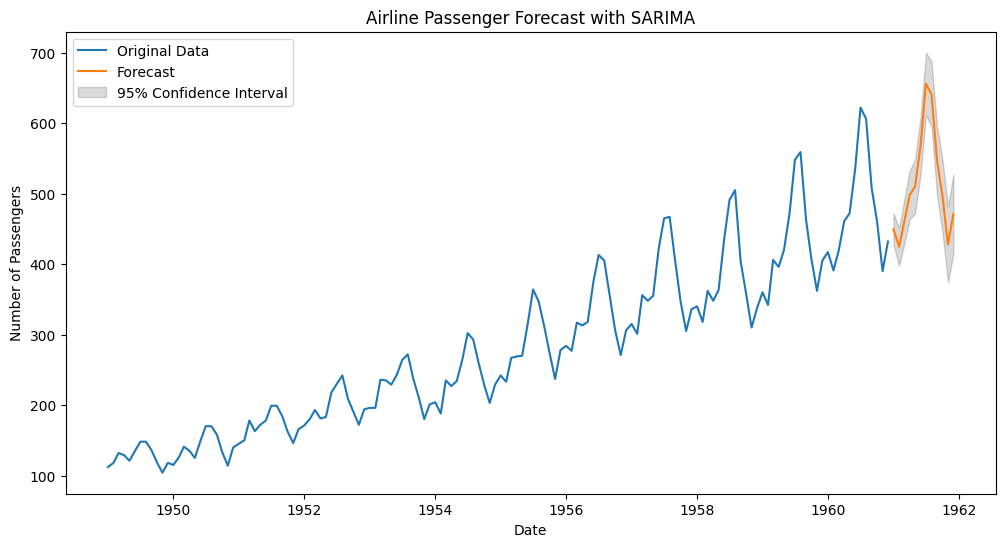

In [32]:
#3. Train a SARIMA model on the monthly airline passengers dataset. Forecast the next 12 months and visualize the results.

# Load the dataset (replace 'AirPassengers.csv' with your actual file path)

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')


# Visualize the original data
plt.figure(figsize=(12, 6))
plt.plot(df, label='Original Data')
plt.title('Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Assuming preprocessing like differencing has been done to achieve stationarity
#  (e.g., using log transformation and differencing, not shown here for brevity)

#  Define SARIMA model parameters (example values, replace with values determined in step 3)
#  (p,d,q) x (P,D,Q,s)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly data, seasonal period 12

#  Train the SARIMA model
model = SARIMAX(df['Passengers'], order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

#  Forecast the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

#  Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df, label='Original Data')
plt.plot(forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15, label='95% Confidence Interval')
plt.title('Airline Passenger Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


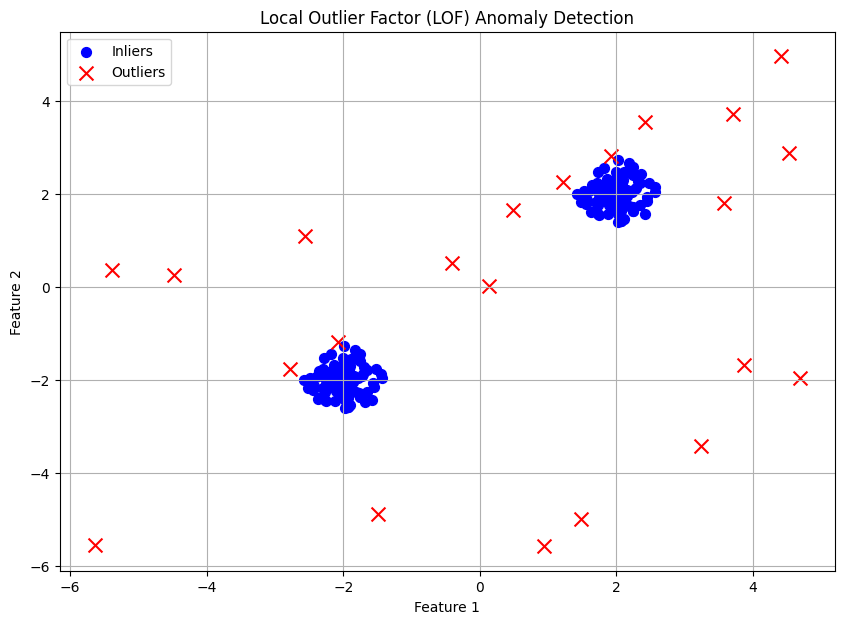

In [34]:
#4. Apply Local Outlier Factor (LOF) on any numerical dataset to detect anomalies and visualize them using matplotlib.

# 1. Generate a numerical dataset with outliers
np.random.seed(42)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2] # Create two clusters

# Generate some outliers
X_outliers = np.random.uniform(low=-6, high=6, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

# 2. Apply Local Outlier Factor (LOF)
# n_neighbors: number of neighbors to consider for local density estimation
# contamination: proportion of outliers in the dataset (can be 'auto' or a float)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(X) # -1 for outliers, 1 for inliers

# Get the negative outlier factor scores (lower is more outlier-like)
# Note: LOF returns negative_outlier_factor_ for outlier detection,
# where lower values (more negative) indicate higher outlier scores.
# For visualization, we often want a positive score, so we can negate it.
outlier_scores = -lof.negative_outlier_factor_

# 3. Visualize anomalies using matplotlib
plt.figure(figsize=(10, 7))
# Plot inliers
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], c='blue', s=50, label='Inliers')
# Plot outliers
plt.scatter(X[y_pred == -1, 0], X[y_pred == -1, 1], c='red', s=100, marker='x', label='Outliers')

# Optionally, visualize the outlier score by point size
# s_scaled = (outlier_scores - outlier_scores.min()) / (outlier_scores.max() - outlier_scores.min()) * 200 + 50
# plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='RdBu', s=s_scaled)

plt.title("Local Outlier Factor (LOF) Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
#5. You are working as a data scientist for a power grid monitoring company. Your goal is to forecast energy demand and also detect abnormal spikes or drops in real-time consumption data collected every 15 minutes. The dataset includes features like timestamp, region, weather conditions, and energy usage.
# Explain your real-time data science workflow:
# ● How would you detect anomalies in this streaming data (Isolation Forest / LOF / DBSCAN)?
# ● Which time series model would you use for short-term forecasting (ARIMA / SARIMA / SARIMAX)?
# ● How would you validate and monitor the performance over time?
# ● How would this solution help business decisions or operations?




